In [ ]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score




# Data

In [ ]:
# ========================
# Dataset preparation
# ========================
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels


In [ ]:
img_size = 256
transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

In [ ]:
train_ds = RetinaMultiLabelDataset(csv_file="../data/train.csv", 
                                   image_dir="../data/images/train/", 
                                   transform=transform)

val_ds = RetinaMultiLabelDataset(csv_file="../data/val.csv", 
                                 image_dir="../data/images/val/", 
                                 transform= transform)

test_ds = RetinaMultiLabelDataset(csv_file="../data/offsite_test.csv", 
                                  image_dir="../data/images/offsite_test/", 
                                  transform= transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
sample = train_ds[0]

In [ ]:
sample[0].shape

torch.Size([3, 256, 256])

In [ ]:
sample[1]

tensor([1., 0., 0.])

In [ ]:
sample[0].min(), sample[0].max(), sample[0].dtype

(tensor(-2.1179), tensor(2.0605), torch.float32)

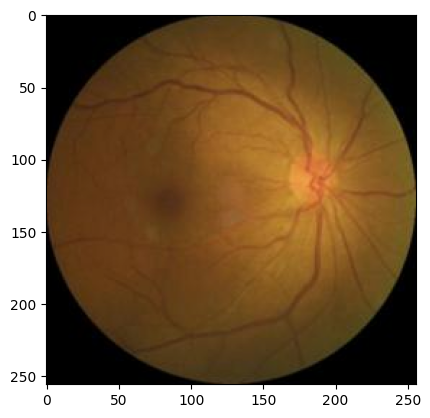

In [ ]:
import matplotlib.pyplot as plt
denormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)
sample = (denormalize(sample[0]), sample[1])
plt.imshow(sample[0].permute(1, 2, 0))
plt.show()

# Model

In [ ]:
# ========================
# build model
# ========================
def build_model(backbone="resnet18", num_classes=3, pretrained=True):

    if backbone == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif backbone == "efficientnet":
        model = models.efficientnet_b0(pretrained=pretrained)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Unsupported backbone")
    return model

In [ ]:
model = build_model(backbone="resnet18", num_classes=3, pretrained=True)
model

/home/ahmed/miniconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ahmed/miniconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
state_dict = torch.load("../pretrained_backbone/ckpt_resnet18_ep50.pt", map_location=torch.device('cpu'))
model.load_state_dict(state_dict)


/tmp/ipykernel_37763/246291703.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("../pretrained_backbone/ckpt_resnet18_ep50.pt", map_location=torch

<All keys matched successfully>

# Transfer Learning

## Task1.1: No fine-tuning: Evaluate directly on ODIR test set.

In [ ]:
model.eval()
for param in model.parameters():
    param.requires_grad = False


In [ ]:
# Evaluate directly on ODIR test set
import numpy as np

def test_model(model,backbone, dataloader, device):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    # y_true = torch.tensor(np.vstack(y_true)).numpy()
    # y_pred = torch.tensor(np.vstack(y_pred)).numpy()
    y_true = torch.tensor(y_true).numpy()
    y_pred = torch.tensor(y_pred).numpy()
    
    result = {}
    disease_names = ["DR", "Glaucoma", "AMD"]
    for i, disease in enumerate(disease_names):  #compute metrics for every disease
        y_t = y_true[:, i]
        y_p = y_pred[:, i]

        acc = accuracy_score(y_t, y_p)
        precision = precision_score(y_t, y_p, average="macro",zero_division=0)
        recall = recall_score(y_t, y_p, average="macro",zero_division=0)
        f1 = f1_score(y_t, y_p, average="macro",zero_division=0)
        kappa = cohen_kappa_score(y_t, y_p)

        print(f"{disease} Results [{backbone}]")
        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1-score : {f1:.4f}")
        print(f"Kappa    : {kappa:.4f}")


        result[disease] = {
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "cohen_kappa": kappa
        }
    
    avg_f1 = f1_score(y_true, y_pred, average="macro",zero_division=0)
    result['avg'] = {"f1_score": avg_f1, "accuracy": -1, "precision": -1, "recall": -1, "cohen_kappa": -1}
    return result

In [ ]:
res = test_model(model, "resnet18", test_loader, device=torch.device('cpu'))


DR Results [resnet18]
Accuracy : 0.5150
Precision: 0.5170
Recall   : 0.5202
F1-score : 0.4958
Kappa    : 0.0339
Glaucoma Results [resnet18]
Accuracy : 0.7850
Precision: 0.7063
Recall   : 0.6784
F1-score : 0.6893
Kappa    : 0.3804
AMD Results [resnet18]
Accuracy : 0.7850
Precision: 0.6305
Recall   : 0.7597
F1-score : 0.6472
Kappa    : 0.3211


/tmp/ipykernel_37763/3217074558.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/utils/tensor_new.cpp:278.)
  y_true = torch.tensor(y_true).numpy()


In [ ]:
res

{'DR': {'accuracy': 0.515,
  'precision': 0.517001700170017,
  'recall': 0.5202380952380952,
  'f1_score': 0.49582889368226823,
  'cohen_kappa': 0.033864541832669404},
 'Glaucoma': {'accuracy': 0.785,
  'precision': 0.70625,
  'recall': 0.6784024868225436,
  'f1_score': 0.6892951334947073,
  'cohen_kappa': 0.3804034582132565},
 'AMD': {'accuracy': 0.785,
  'precision': 0.6305352329611089,
  'recall': 0.7597037793667007,
  'f1_score': 0.6471794871794871,
  'cohen_kappa': 0.32112409220082105},
 'avg': {'f1_score': 0.5125542862217208,
  'accuracy': -1,
  'precision': -1,
  'recall': -1,
  'cohen_kappa': -1}}

In [ ]:
import pandas as pd
df = pd.DataFrame(res).T
df

,accuracy,precision,recall,f1_score,cohen_kappa
DR,0.515,0.517002,0.520238,0.495829,0.033865
Glaucoma,0.785,0.706250,0.678402,0.689295,0.380403
AMD,0.785,0.630535,0.759704,0.647179,0.321124
avg,-1.000,-1.000000,-1.000000,0.512554,-1.000000


In [ ]:
df.reset_index()

,index,accuracy,precision,recall,f1_score,cohen_kappa
0,DR,0.515,0.517002,0.520238,0.495829,0.033865
1,Glaucoma,0.785,0.706250,0.678402,0.689295,0.380403
2,AMD,0.785,0.630535,0.759704,0.647179,0.321124
3,avg,-1.000,-1.000000,-1.000000,0.512554,-1.000000


## Task1.2: Frozen backbone, fine-tune classifier only

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for nam, param in model.named_parameters():
    if "fc" not in nam:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
lr = 1e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)


In [ ]:
def init_data(backbone="resnet18", num_classes=3, pretrained=True):
    build_model()
    pass

In [ ]:
def init_model():
    pass

In [ ]:
def init_optimizer():
    pass

In [ ]:
def train_one_epoch(backbone, train_csv, val_csv, test_csv, train_image_dir, val_image_dir, test_image_dir, 
                       epochs=10, batch_size=32, lr=1e-4, img_size=256, save_dir="checkpoints",pretrained_backbone=None):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader = init_data()
    model = init_model(backbone, )
    optimizer = init_optimizer(model, lr)

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"[{backbone}] Epoch {epoch+1}/{epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), ckpt_path)
        print(f"Saved best model for {backbone} at {ckpt_path}")


## Task1.3: Full fine-tuning